In [34]:
# Imports
import sys
import os
import numpy as np
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.Material import unitDensityMaterial
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import DiffusionTestParticle
from electronTransportCode.SimOptions import DiffusionPointSource
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
%matplotlib widget


In [35]:
b = 0.2  # Parameters of transformation

# Initialize simulation parameters
Emax = 5.0
xbins = 512
xmax = 15.0

# Initialize Advection-Diffusion parameters (No advection)
stoppingPower = f'{b}*(1 + E**2)'
scatteringRate1 = 1
scatteringRate2 = 10
scatteringRate3 = 50
varH = 1/3  # 1 in 1D, 1/3 in 3D
sigmaInit = 1
muInit = 0.0

# initialize the equation and the space
eq1 = PDE({"φ": f"laplace({varH}*φ/({stoppingPower.replace('E', f'({Emax}-t)')}*{scatteringRate1}))"})
eq2 = PDE({"φ": f"laplace({varH}*φ/({stoppingPower.replace('E', f'({Emax}-t)')}*{scatteringRate2}))"})
eq3 = PDE({"φ": f"laplace({varH}*φ/({stoppingPower.replace('E', f'({Emax}-t)')}*{scatteringRate3}))"})

grid = CartesianGrid([(-xmax, xmax)], [xbins], periodic=True)
state1 = ScalarField.from_expression(grid, f"exp(-0.5*((x-{muInit})/{sigmaInit})**2)/({sigmaInit}*sqrt(2*{np.pi}))*{stoppingPower.replace('E', str(Emax))}")

# solve the equation and store the trajectory
storage1 = MemoryStorage()
result1 = eq1.solve(state1, t_range=Emax, tracker=storage1.tracker(1), dt=1e-5)

storage2 = MemoryStorage()
result2 = eq2.solve(state1, t_range=Emax, tracker=storage2.tracker(1), dt=1e-5)

storage3 = MemoryStorage()
result3 = eq3.solve(state1, t_range=Emax, tracker=storage3.tracker(1), dt=1e-5)

In [36]:
# Initialize Monte Carlo Algorithm

# Set up simulation domain
ymin = -xmax; ymax = xmax; ybins = 2
zmin = -xmax; zmax = xmax; zbins = 2
simDomain = SimulationDomain(ymin, ymax, zmin, zmax, ybins, zbins, material=unitDensityMaterial)

# Set up initial conditions
NB_PARTICLES = 30000
SEED: int = 4  # Random number generator seed
pointSourceSim = DiffusionPointSource(minEnergy=0.0, rngSeed=SEED, eSource=Emax, loc=muInit, std=sigmaInit)

# Scattering angle must be independent of previous angle!
DiffusionPointSource.SAMPLE_NEW_ABSOLUTE_DIRECTION = True  # type: ignore

# Set up estimator and particle
trackEndEstimatorx1 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')
trackEndEstimatorx2 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')
trackEndEstimatorx3 = TrackEndEstimator(simDomain, NB_PARTICLES, setting='x')

particle1 = DiffusionTestParticle(Es=scatteringRate1, sp=stoppingPower)
particle2 = DiffusionTestParticle(Es=scatteringRate2, sp=stoppingPower)
particle3 = DiffusionTestParticle(Es=scatteringRate3, sp=stoppingPower)

particleTracer1 = AnalogParticleTracer(particle=particle1, simOptions=pointSourceSim, simDomain=simDomain)
particleTracer2 = AnalogParticleTracer(particle=particle2, simOptions=pointSourceSim, simDomain=simDomain)
particleTracer3 = AnalogParticleTracer(particle=particle3, simOptions=pointSourceSim, simDomain=simDomain)

# Run simulation
particleTracer1(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx1), logAmount=5000)

Last 5000 particles took 1.14194696100094 seconds. 16.666666666666668% completed.
Last 5000 particles took 1.1214796599997499 seconds. 33.333333333333336% completed.
Last 5000 particles took 1.1263095089998387 seconds. 50.0% completed.
Last 5000 particles took 1.0599543399985123 seconds. 66.66666666666667% completed.
Last 5000 particles took 1.15872556800241 seconds. 83.33333333333333% completed.
Last 5000 particles took 1.1412939829970128 seconds. 100.0% completed.


In [37]:
particleTracer2(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx2), logAmount=5000)

Last 5000 particles took 34.59791918599876 seconds. 16.666666666666668% completed.
Last 5000 particles took 34.08346609900036 seconds. 33.333333333333336% completed.
Last 5000 particles took 34.02648953300013 seconds. 50.0% completed.
Last 5000 particles took 33.59165872900121 seconds. 66.66666666666667% completed.
Last 5000 particles took 33.74396629900002 seconds. 83.33333333333333% completed.
Last 5000 particles took 34.24695215899919 seconds. 100.0% completed.


In [38]:
particleTracer3(nbParticles=NB_PARTICLES, estimators=(trackEndEstimatorx3), logAmount=5000)

Last 5000 particles took 177.42487007900127 seconds. 16.666666666666668% completed.
Last 5000 particles took 177.15285775699886 seconds. 33.333333333333336% completed.
Last 5000 particles took 177.0290917179991 seconds. 50.0% completed.
Last 5000 particles took 177.30517593199693 seconds. 66.66666666666667% completed.
Last 5000 particles took 177.67120974700083 seconds. 83.33333333333333% completed.
Last 5000 particles took 179.08872242299913 seconds. 100.0% completed.


Text(0.5, 0.98, 'Advection-Diffusion limit test with energy-dependent stopping power')

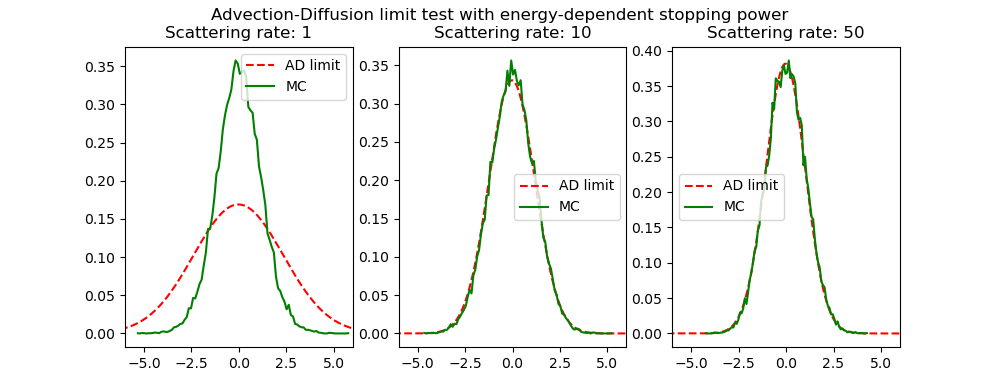

In [39]:
# Plot solutions

# Stopping power at xres
xres = np.linspace(-xmax, xmax, xbins, endpoint=False)
sp_xres = np.zeros_like(xres)
for index, x in enumerate(xres):
    sp_xres[index] = particle1.evalStoppingPower(Emax, np.array((x, None, None), dtype=float), None)

# Advection-diffusion solution
ADres1 = storage1.data[-1]/sp_xres
ADres2 = storage2.data[-1]/sp_xres
ADres3 = storage3.data[-1]/sp_xres

# MC solution 1
xdensity1 = trackEndEstimatorx1.scoreMatrix
binVal1, binEdge1 = np.histogram(xdensity1, bins=100, density=True)
binCenter1 = (binEdge1[:-1] + binEdge1[1:])/2.0

# MC solution 2
xdensity2 = trackEndEstimatorx2.scoreMatrix
binVal2, binEdge2 = np.histogram(xdensity2, bins=100, density=True)
binCenter2 = (binEdge2[:-1] + binEdge2[1:])/2.0

# MC solution 2
xdensity3 = trackEndEstimatorx3.scoreMatrix
binVal3, binEdge3 = np.histogram(xdensity3, bins=100, density=True)
binCenter3 = (binEdge3[:-1] + binEdge3[1:])/2.0

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.9))

ax1.plot(xres, ADres1, 'r--', label=f'AD limit')
ax1.plot(binCenter1, binVal1, 'g', label=f'MC')
ax1.set_xlim((-6, 6))
ax1.legend()
ax1.set_title(f'Scattering rate: {scatteringRate1}')

ax2.plot(xres, ADres2, 'r--', label=f'AD limit')
ax2.plot(binCenter2, binVal2, 'g', label=f'MC')
ax2.set_xlim((-6, 6))
ax2.legend()
ax2.set_title(f'Scattering rate: {scatteringRate2}')

ax3.plot(xres, ADres3, 'r--', label=f'AD limit')
ax3.plot(binCenter3, binVal3, 'g', label=f'MC')
ax3.set_xlim((-6, 6))
ax3.legend()
ax3.set_title(f'Scattering rate: {scatteringRate3}')

fig.suptitle('Advection-Diffusion limit test with energy-dependent stopping power')

In [40]:
ADres3 == ADres1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,